In [45]:
import pandas as pd
import numpy as np

import plotly.graph_objects as go
import plotly.subplots as sp
import plotly.express as px
import plotly.figure_factory as ff
import random

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from ipywidgets import interactive

import seaborn as sns
from data_generators import create_site_data

from functools import reduce
from flexitext import flexitext
from scipy.special import expit

In [46]:
years = list(range(2020, 2051))
first_df = create_site_data(years = years)

# Sum horizontally across year columns and create a 'Total' column
first_df['Total'] = first_df.loc[:, [f'Year_{year}' for year in years]].sum(axis=1)


In [47]:
# Select columns that aren't years
subset_columns = ['program1', 'program2', 'program3', 'program4', 'Total']

# Create a new DataFrame with the selected columns
df = first_df.loc[:, subset_columns]

# Display the new DataFrame
df.head()

,program1,program2,program3,program4,Total
0,site3,site7.1,site4.2,,211
1,site4,site2.1,site7.2,site3.3,340
2,site1,site2.1,site3.2,site3.3,249
3,site3,site4.1,site6.2,site3.3,384
4,site3,site2.1,site2.2,site4.3,119


In [103]:
grouped_programs = df.groupby(["program1","program2","program3"]).sum()["Total"].reset_index()

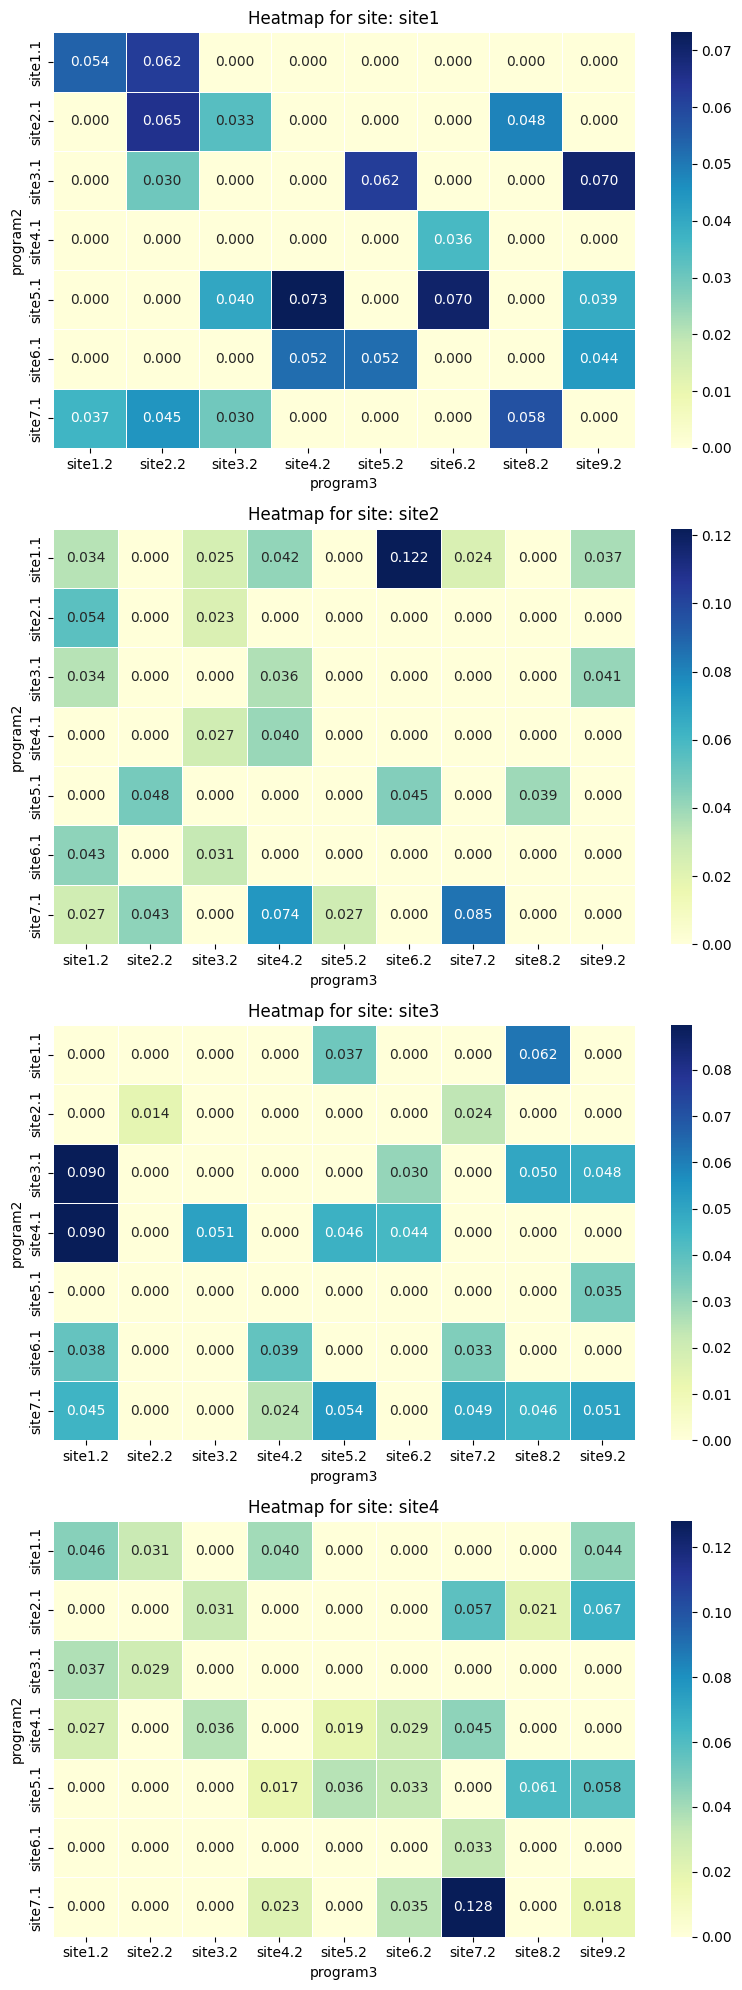

In [104]:
site_dfs = {}
for program in grouped_programs["program1"].unique().tolist():
    sub_df = grouped_programs[grouped_programs["program1"] == program]
    sub_df["proportions"] = sub_df["Total"].apply(lambda x: x / sub_df["Total"].sum())
    sub_df = sub_df[["program2","program3","proportions"]]
    site_dfs[program]  = sub_df

num_plots = len(site_dfs.keys())
fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(8, 5 * num_plots))

for i, (site, site_df) in enumerate(site_dfs.items()):
    categories = list(site_df["program2"].unique())
    sorted_categories = sorted(categories, key=str.lower)

    site_df["program2"] = pd.Categorical(
        site_df["program2"], 
        categories=sorted_categories, 
        ordered=True
    )
    
    # Finally, sort the values in the data frame according to this custom sort.
    site_df = site_df.sort_values("program2", ascending=False)

    sns.heatmap(
        site_df.pivot(index='program2', columns='program3', values='proportions').fillna(0), 
        annot=True, 
        cmap='YlGnBu', 
        fmt=".3f", 
        linewidths=.5,
        ax=axes[i]
    )
    axes[i].set_title(f'Heatmap for site: {site}')
plt.tight_layout()

plt.show()

In [38]:
data_to_graph = first_df.groupby(["program1","program2"]).sum()[[f'Year_{year}' for year in years]].reset_index()

In [44]:
data_to_graph.head(5)

,program1,program2,Year_2020,Year_2021,Year_2022,Year_2023,Year_2024,Year_2025,Year_2026,Year_2027,...,Year_2041,Year_2042,Year_2043,Year_2044,Year_2045,Year_2046,Year_2047,Year_2048,Year_2049,Year_2050
0,site1,site1.1,2,25,30,9,6,20,20,45,...,6,1,97,8,27,0,0,2,10,54
1,site1,site2.1,11,27,8,2,154,21,7,13,...,18,32,67,13,35,54,22,26,48,100
2,site1,site3.1,32,2,6,41,30,28,45,106,...,15,27,28,13,27,9,3,13,16,144
3,site1,site4.1,8,2,2,5,10,93,5,2,...,32,4,18,20,2,1,4,2,4,0
4,site1,site5.1,156,98,84,6,14,47,21,105,...,115,10,6,70,29,13,49,128,25,17


In [39]:
def plot_time_series(data_to_graph):
    """Plot overlapping timeseries with average time series spanning each subplot

    Args:
        data_to_graph (pd.DataFrame): 
            {
                "Prog1" : list of programs,
                "Prog2" : List of subprograms,
                "Year1" : List of years,
                ...
                ...
                "Year N" : List of Years
            }
    """
    fig, axes = plt.subplots(4, 1, figsize=(14, 7), sharey=True)
    plt.subplots_adjust(hspace=0.8)
    
    sites = data_to_graph["program1"].unique().tolist()
    plasma_colormap = matplotlib.cm.get_cmap("plasma")
    COLORS = [plasma_colormap(x) for x in np.linspace(0.8, 0.15, num=len(sites))]
    COLORS = [matplotlib.colors.to_hex(color) for color in COLORS]
    
    for i, (site, color) in enumerate(zip(sites,COLORS)):
        subdf = data_to_graph[data_to_graph["program1"] == site]
        subdf = subdf[subdf.columns.tolist()[1:]]
        subdf = subdf.set_index("program2")
        subdf = subdf.T
        avg_values = subdf.mean(axis=1)
        for col in subdf.columns:
            vals_to_plot = subdf[col].values
            index = [i for i in range(len(subdf.index.tolist()))]
            axes[i].plot(index, vals_to_plot, color=color, alpha=0.2, lw=1.5)
            axes[i].set_xticks(index)
            axes[i].set_xticklabels([y.strip("Year_") for y in subdf.index.tolist()], rotation=45, ha='right')  # Adjust rotation and alignment as needed
            axes[i].set_ylabel('Values')
            axes[i].set_title(f'{site}')
    
        axes[i].plot(avg_values, color=color, lw=2, label=f'{site} (Average)')
        axes[i].legend(loc='upper right')
        # Set x-axis labels and ticks
        axes[i].set_xticks(range(len(avg_values)))
        axes[i].set_xticklabels([y.strip("Year_") for y in subdf.index.tolist()], rotation=45, ha='right')
    
    # Add legend
    plt.legend(loc='upper right')
    
    # Show the plot
    plt.show()

C:\Users\ajfon\AppData\Local\Temp\ipykernel_22452\1604451117.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plasma_colormap = matplotlib.cm.get_cmap("plasma")


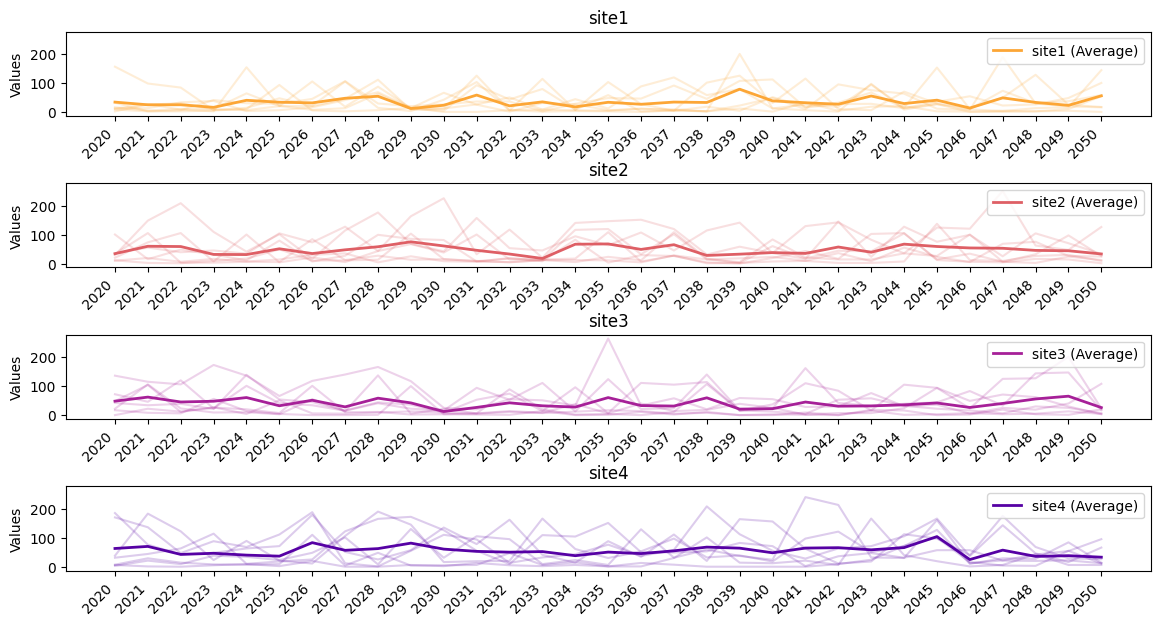

In [43]:
plot_time_series(data_to_graph = data_to_graph)